c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Total de documentos 'RAG' carregados: 0



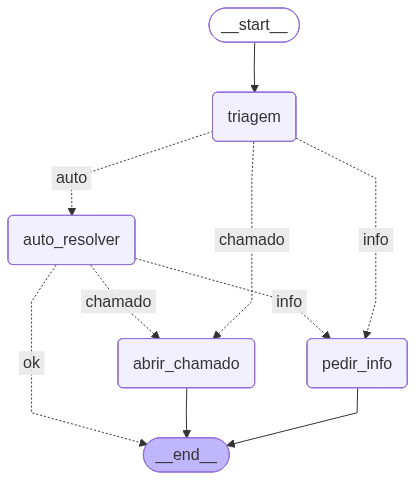

In [2]:
from typing import TypedDict, Optional, List
from langgraph.graph import StateGraph, START, END
from triagem import triagem
from import_pdf_splitter_embedding import perguntar_politica_RAG
from IPython.display import display, Image



class AgentState(TypedDict, total = False):
  pergunta: str
  triagem: dict
  resposta: Optional[str]
  citacoes: List[dict]
  rag_sucesso: bool
  acao_final: str




# ========================== DEFINIÇÃO DOS NÓS PARA A DECISÃO DA IA ==========================================
def node_triagem(state: AgentState) -> AgentState:
  print("Executando nó de triagem...")
  return {"triagem": triagem(state["pergunta"])} 

def node_auto_resolver(state: AgentState) -> AgentState:
  print("Executando nó de auto_resolver...")
  resposta_rag = perguntar_politica_RAG(state["pergunta"])

  update: AgentState = {
    "resposta": resposta_rag["answer"],
    "citacoes": resposta_rag.get("citacoes", []),
    "rag_sucesso": resposta_rag["contexto_encontrado"],
  }

  if resposta_rag["contexto_encontrado"]:
    update["acao_final"] = "AUTO_RESOLVER"

  return update

def node_pedir_info(state: AgentState) -> AgentState:
  print("Executando nó de pedir_info...")
  faltantes = state["triagem"].get("campos_faltantes", [])

  if faltantes:
    detalhe = ",".join(faltantes)
  else:
    detalhe = "Tema e contexto específico"

  return {
    "resposta": f"Para avançar, preciso que detalhe: {detalhe}",
    "citacoes": [],
    "acao_final": "PEDIR_INFO"
  }

def node_abrir_chamado(state: AgentState) -> AgentState:
  print("Executando nó de abrir_chamado...")
  triagem = state["triagem"]

  return {
    "resposta": f"Abrindo chamado com urgência {triagem['urgencia']}. Descrição: {state['pergunta'][:140]}",
    "citacoes": [],
    "acao_final": "ABRIR_CHAMADO"
  }





KEYWORDS_ABRIR_TICKET = ["aprovação", "exceção", "liberação", "abrir ticket", "abrir chamado", "acesso especial"]

def decidir_pos_triagem(state: AgentState) -> str:
  print("Decidindo após a triagem...")
  decisao = state["triagem"]["decisao"]

  if decisao == "AUTO_RESOLVER": return "auto"
  if decisao == "PEDIR_INFO": return "info"
  if decisao == "ABRIR_CHAMADO": return "chamado"


def decidir_pos_auto_resolver(state: AgentState) -> str:
  print("Decidindo após o auto_resolver...")

  if state.get("rag_sucesso"):
    print("Rag com sucesso, finalizando o fluxo.")
    return "ok"

  state_da_pergunta = (state["pergunta"] or "").lower()

  if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET):
    print("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
    return "chamado"

  print("Rag falhou, sem keywords, vou pedir mais informações...")
  return "info"




workflow = StateGraph(AgentState)

workflow.add_node("triagem", node_triagem)
workflow.add_node("auto_resolver", node_auto_resolver)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)

workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
  "auto": "auto_resolver",
  "info": "pedir_info",
  "chamado": "abrir_chamado"
})

workflow.add_conditional_edges("auto_resolver", decidir_pos_auto_resolver, {
  "info": "pedir_info",
  "chamado": "abrir_chamado",
  "ok": END
})

workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()




graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

